In [11]:
from torch import nn,save,load
from torch.optim import Adam
from torch.utils.data import DataLoader 
from torchvision import datasets
from torchvision.transforms import ToTensor

In [12]:
train  = datasets.MNIST(root="data",download=True,train=True,transform=ToTensor())

In [13]:
dataset = DataLoader(train,32)
#image shape (1,28,28)

In [18]:
#0-9 classes
class ImageClassification(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
        nn.Conv2d(1,32,(3,3)),
        nn.ReLU (),
        nn.Conv2d(32,64,(3,3)),
        nn.ReLU (),
        nn.Conv2d(64,64,(3,3)),
        nn.ReLU (),
        nn.Flatten(),
        nn.Linear(64*(28-6)*(28-6),10))
  def forward(self,x):
    return self.model(x)

In [19]:
!nvidia-smi

Mon Dec 19 00:14:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| N/A   51C    P8     4W /  N/A |    199MiB /  4096MiB |     33%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [20]:
#creating instance of NN loss and Optimizer
clf = ImageClassification().to('cuda')
opt = Adam(clf.parameters(),lr = 1e-3)
loss_fn = nn.CrossEntropyLoss()

In [21]:
#Training Function
from tqdm import tqdm

if __name__ == "__main__":
  #run Dl for no.of epoch 
  for epoch in range(10): #trains for 10 epoch
    for batch in tqdm(dataset):
      X,y = batch
      X, y = X.to('cuda'), y.to('cuda')
      yhat = clf(X)
      loss = loss_fn(yhat,y)

      #apply backprop
      opt.zero_grad()
      loss.backward()
      opt.step()

  print(f"Epoch:{epoch} loss is {loss.item()}")

with open('model_state.pt','wb') as f:
  save(clf.state_dict(),f)

100%|██████████| 1875/1875 [00:17<00:00, 106.45it/s]

Epoch:9 loss is 6.399397079803748e-06


In [22]:
with open('model_state.pt','wb') as f:
  save(clf.state_dict(),f)

tensor(7, device='cuda:0')


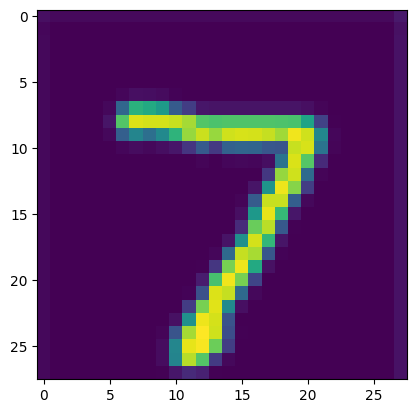

In [25]:
import matplotlib.pyplot as plt
import torch 
from PIL import Image
with open('model_state.pt',"rb") as f:
  clf.load_state_dict(load(f))
image = Image.open('/home/kalyan/gitrepo/AI-ML-Playground/PyTorch/MNIST/data/sample_image.png')
img = image.convert('L')
#reshaping to weight 1,3,1480,1490
img = img.resize((28,28))
img_tensor = ToTensor()(img).unsqueeze(0).to('cuda')

print(torch.argmax(clf(img_tensor)))
plt.imshow(img)


## Making Custom Layers 
#### Started with MyReLU onto CustomConv2d (tried , failed with too much errors)

In [26]:
import torch
from torch.autograd import Variable 
dtype = torch.FloatTensor
dtype = torch.cuda.FloatTensor #to run on gpu

N, D_in , H, D_out = 64, 1000,100,10
x = Variable(torch.randn(N,D_in).type(dtype), requires_grad=False)
y = Variable(torch.randn(N,D_out).type(dtype), requires_grad=False)

w1 = Variable(torch.randn(D_in,H).type(dtype), requires_grad=True)
w2 = Variable(torch.randn(H,D_out).type(dtype), requires_grad=True)

In [27]:
learning_rate = 1e-6
for t in range(500):
    y_pred = x.mm(w1).clamp(min=0).mm(w2)
    ##mm is matrix multiplication and clamp , clamps both all the values in the input range between a min and max values

    #calculate loss
    '''Now to compute the loss we are using the same popular loss function , sum of all squared difference of y_pred and y 
Loss is a variable of shape(1,) and loss.data is a Tensor of shape (1,) ; loss.data[0] is a scalar value holding loss'''
    loss = (y_pred - y).pow(2).sum()
    print(t, loss.data)
    '''Now we need to set the gradients of both sets of weights to 0 since graident buffers needs to be reset before fresh gradients are calculated'''

    '''now we will use autograd to compute the backward pass . this call will compute the gradient of loss wrt all variables with ```requires_grad=True``` 
after this w1.grad and w2.grad will be variables holding the grad of the loss wrt w1 and w2'''
    loss.backward()

    '''now we will update the weights using gradient descent . for this we will just mutate the values of w1 and w2 in place .'''
    w1.data -= learning_rate*w1.grad.data
    w2.data -= learning_rate*w2.grad.data
    w1.grad.data.zero_()
    w2.grad.data.zero_()

0 tensor(33841608., device='cuda:0')
1 tensor(31044728., device='cuda:0')
2 tensor(30585010., device='cuda:0')
3 tensor(27946280., device='cuda:0')
4 tensor(21782888., device='cuda:0')
5 tensor(14337496., device='cuda:0')
6 tensor(8330550., device='cuda:0')
7 tensor(4691116., device='cuda:0')
8 tensor(2776861.5000, device='cuda:0')
9 tensor(1812324.8750, device='cuda:0')
10 tensor(1304040.1250, device='cuda:0')
11 tensor(1010164.2500, device='cuda:0')
12 tensor(820557.3125, device='cuda:0')
13 tensor(685870.4375, device='cuda:0')
14 tensor(583043.3750, device='cuda:0')
15 tensor(501065.7812, device='cuda:0')
16 tensor(433868.7500, device='cuda:0')
17 tensor(377906.1250, device='cuda:0')
18 tensor(330810.1875, device='cuda:0')
19 tensor(290862.3125, device='cuda:0')
20 tensor(256769.9531, device='cuda:0')
21 tensor(227479.4219, device='cuda:0')
22 tensor(202188.6875, device='cuda:0')
23 tensor(180282.4375, device='cuda:0')
24 tensor(161207.5625, device='cuda:0')
25 tensor(144532.5938, d

In [28]:
train  = datasets.MNIST(root="data",download=True,train=True,transform=ToTensor())
dataset = DataLoader(train,32)
#image shape (1,28,28)

In [29]:
#trying using MyReLU
class MyReLU(nn.Module):
    def forward(self, input):
        self.save_for_backward(input)
        return input.clamp(min=0)
    def backward(self, grad_output):
        input, = self.saved_tensors
        grad_input = grad_output.clone()
        grad_input[input<0] = 0
        return grad_input
    def save_for_backward(self,x):
        self.saved_tensors = x
#0-9 classes
class ImageClassification(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1,32,(3,3)),
            MyReLU(),
            nn.Conv2d(32,64,(3,3)),
            MyReLU(),
            nn.Conv2d(64,64,(3,3)),
            MyReLU(),
            nn.Flatten(),
            nn.Linear(64*(28-6)*(28-6),10))
    def forward(self,x):
        return self.model(x)

#creating instance of NN loss and Optimizer
clf = ImageClassification().to('cuda')
opt = Adam(clf.parameters(),lr = 1e-3)
loss_fn = nn.CrossEntropyLoss()

In [30]:
#Training Function
from tqdm import tqdm

if __name__ == "__main__":
  #run Dl for no.of epoch 
  for epoch in range(10): #trains for 10 epoch
    for batch in tqdm(dataset):
      X,y = batch
      X, y = X.to('cuda'), y.to('cuda')
      yhat = clf(X)
      loss = loss_fn(yhat,y)

      #apply backprop
      opt.zero_grad()
      loss.backward()
      opt.step()

  print(f"Epoch{epoch} loss is {loss.item()}")

with open('model_state.pt','wb') as f:
  save(clf.state_dict(),f)

100%|██████████| 1875/1875 [00:11<00:00, 162.22it/s]

Epoch9 loss is 5.98248061578488e-06


In [31]:
with open('model_state.pt','wb') as f:
  save(clf.state_dict(),f)

tensor(7, device='cuda:0')


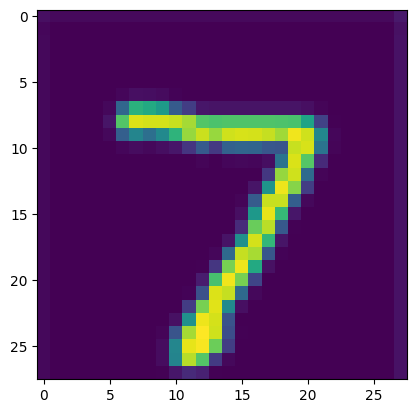

In [33]:
#predicting
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def predict(img,model):
    x = ToTensor()(img).unsqueeze(0).to('cuda')
    yhat = model(x)
    return yhat.argmax()

img = Image.open('/home/kalyan/gitrepo/AI-ML-Playground/PyTorch/MNIST/data/sample_image.png')
#convertin to 1 channel
img = img.convert('L')
#reshaping to weight 1,3,1480,1490
img = img.resize((28,28))
plt.imshow(img)
print(predict(img,clf))

In [24]:
import math
from torch import nn
from torch import save,load
from torch.nn import functional as F
from torch.optim import Adam
#trying using MyReLU
class MyReLU(nn.Module):
    def forward(self, input):
        self.save_for_backward(input)
        return input.clamp(min=0)
    def backward(self, grad_output):
        input, = self.saved_tensors
        grad_input = grad_output.clone()
        grad_input[input<0] = 0
        return grad_input
    def save_for_backward(self,x):
        self.saved_tensors = x
class MyConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.groups = groups
        self.bias = bias
        self.weight = nn.Parameter(torch.Tensor(out_channels, in_channels // groups, *kernel_size))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(out_channels))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)

    def forward(self, input):
        return F.conv2d(input, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)

#0-9 classes
'''class ImageClassification(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1,32,(3,3)),
            MyReLU(),
            nn.Conv2d(32,64,(3,3)),
            MyReLU(),
            nn.Conv2d(64,64,(3,3)),
            MyReLU(),
            nn.Flatten(),
            nn.Linear(64*(28-6)*(28-6),10))
    def forward(self,x):
        return self.model(x)

#creating instance of NN loss and Optimizer
clf = ImageClassification().to('cuda')

# Define the optimizer and loss function
opt = Adam(clf.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

from torch.utils.data import DataLoader
# Load your training data
train_loader = DataLoader(train, batch_size=64, shuffle=True)

# Loop over the training data
for inputs, labels in train_loader:
    # Move the input and label tensors to the GPU
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    # Zero out the gradients of the optimizer
    opt.zero_grad()

    # Forward pass
    outputs = clf(inputs)
    loss = loss_fn(outputs, labels)

    # Backward pass
    loss.backward()

    # Update the model weights
    opt.step()'''

"class ImageClassification(nn.Module):\n    def __init__(self):\n        super().__init__()\n        self.model = nn.Sequential(\n            nn.Conv2d(1,32,(3,3)),\n            MyReLU(),\n            nn.Conv2d(32,64,(3,3)),\n            MyReLU(),\n            nn.Conv2d(64,64,(3,3)),\n            MyReLU(),\n            nn.Flatten(),\n            nn.Linear(64*(28-6)*(28-6),10))\n    def forward(self,x):\n        return self.model(x)\n\n#creating instance of NN loss and Optimizer\nclf = ImageClassification().to('cuda')\n\n# Define the optimizer and loss function\nopt = Adam(clf.parameters(), lr=1e-3)\nloss_fn = nn.CrossEntropyLoss()\n\nfrom torch.utils.data import DataLoader\n# Load your training data\ntrain_loader = DataLoader(train, batch_size=64, shuffle=True)\n\n# Loop over the training data\nfor inputs, labels in train_loader:\n    # Move the input and label tensors to the GPU\n    inputs, labels = inputs.to('cuda'), labels.to('cuda')\n\n    # Zero out the gradients of the optimizer

In [34]:
class ImageClassification(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            MyConv2d(1, 32, (3, 3)),
            MyReLU(),
            MyConv2d(32, 64, (3, 3)),
            MyReLU(),
            MyConv2d(64, 64, (3, 3)),
            MyReLU(),
            nn.Flatten(),
            nn.Linear(64*(28-6)*(28-6), 10))
            
    def forward(self, x):
        return self.model(x)


In [35]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.optim import Adam
from tqdm import tqdm
#eval method from pytorch

train_loader = DataLoader(train, batch_size=64, shuffle=True)

def evaluate(model, data_loader, loss_fn):
    model.eval()  # Set the model to evaluation mode

    # Initialize the total loss and correct predictions
    total_loss = 0
    num_correct = 0

    # Loop over the validation data
    with torch.no_grad():  # Disable gradient computation
        for inputs, labels in data_loader:
            # Move the input and label tensors to the GPU
            inputs, labels = inputs.to('cuda'), labels.to('cuda')

            # Forward pass
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            # Update the total loss and number of correct predictions
            total_loss += loss.item() * inputs.size(0)
            num_correct += (outputs.argmax(dim=1) == labels).sum().item()

    # Compute the average loss and accuracy
    avg_loss = total_loss / len(data_loader.dataset)
    accuracy = num_correct / len(data_loader.dataset)

    return avg_loss, accuracy


if __name__ == '__main__':
    model = ImageClassification().to('cuda')

    # Define the optimizer and loss function
    opt = Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss()

    # Load the training and validation data
    train = MNIST(root='data', train=True, transform=ToTensor(), download=True)
    val_loader = DataLoader(MNIST(root='data', train=False, transform=ToTensor()), batch_size=64)
    # Loop over the number of epochs
    for epoch in range(10):
        # Loop over the training data
        for inputs, labels in tqdm(train_loader):
            # Move the input and label tensors to the GPU
            inputs, labels = inputs.to('cuda'), labels.to('cuda')

            # Zero out the gradients of the optimizer
            opt.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            # Backward pass
            loss.backward()

            # Update the model weights
            opt.step()

        # Evaluate the model on the validation set
        val_loss, val_acc = evaluate(model, val_loader, loss_fn)

        # Print the epoch number, validation loss, and validation accuracy
        print(f'Epoch {epoch+1}: val_loss = {val_loss:.4f}, val_acc = {val_acc:.4f}')
    

100%|██████████| 938/938 [00:10<00:00, 88.59it/s] 


Epoch 1: val_loss = 0.0539, val_acc = 0.9835


100%|██████████| 938/938 [00:09<00:00, 103.36it/s]


Epoch 2: val_loss = 0.0357, val_acc = 0.9877


100%|██████████| 938/938 [00:08<00:00, 107.59it/s]


Epoch 3: val_loss = 0.0361, val_acc = 0.9876


100%|██████████| 938/938 [00:08<00:00, 109.89it/s]


Epoch 4: val_loss = 0.0338, val_acc = 0.9894


100%|██████████| 938/938 [00:10<00:00, 93.45it/s] 


Epoch 5: val_loss = 0.0343, val_acc = 0.9900


100%|██████████| 938/938 [00:08<00:00, 110.74it/s]


Epoch 6: val_loss = 0.0486, val_acc = 0.9872


100%|██████████| 938/938 [00:10<00:00, 87.01it/s] 


Epoch 7: val_loss = 0.0454, val_acc = 0.9884


100%|██████████| 938/938 [00:09<00:00, 99.45it/s] 


Epoch 8: val_loss = 0.0483, val_acc = 0.9874


100%|██████████| 938/938 [00:08<00:00, 112.24it/s]


Epoch 9: val_loss = 0.0559, val_acc = 0.9880


100%|██████████| 938/938 [00:08<00:00, 107.71it/s]


Epoch 10: val_loss = 0.0505, val_acc = 0.9898


In [29]:
#Training Function
from tqdm import tqdm

if __name__ == "__main__":
  #run Dl for no.of epoch 
  for epoch in range(10): #trains for 10 epoch
    for batch in tqdm(dataset):
      X,y = batch
      X, y = X.to('cuda'), y.to('cuda')
      yhat = clf(X)
      loss = loss_fn(yhat,y)

      #apply backprop
      opt.zero_grad()
      loss.backward()
      opt.step()

  print(f"Epoch{epoch} loss is {loss.item()}")

with open('model_state.pt','wb') as f:
  save(clf.state_dict(),f)

100%|██████████| 1875/1875 [00:14<00:00, 131.30it/s]

Epoch9 loss is 0.006044051609933376


tensor(7, device='cuda:0')


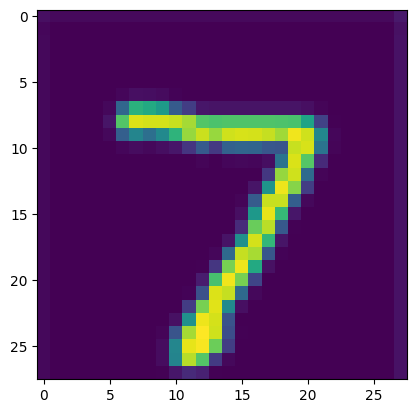

In [33]:
#predicting
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def predict(img,model):
    x = ToTensor()(img).unsqueeze(0).to('cuda')
    yhat = model(x)
    return yhat.argmax()

img = Image.open('/home/kalyan/gitrepo/AI-ML-Playground/PyTorch/MNIST/data/sample_image.png')
#convertin to 1 channel
img = img.convert('L')
#reshaping to weight 1,3,1480,1490
img = img.resize((28,28))
plt.imshow(img)
print(predict(img,clf))